# Diabetic Retinopathy

## Load Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import class_weight # Estimates class weights for unbalanced datasets.

## Load and Normalize training and test datasets using torchvision

In [2]:
# Pirnt number of image files in directory
print(len(os.listdir('./notebooks/train_images/')))

3662


In [3]:
# Get device for training
def get_device():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f'Using {device.upper()} device!')
    return device


In [4]:
# Assign device 
device = get_device()

# Images path
images_path = './notebooks/train_images/'

# Labels path
labels_path = './notebooks/train.csv'

# Load labels DF
labels_df = pd.read_csv(labels_path)

# Create a Custom Dataset for images
class CustomImageDataset(Dataset):
    """
    Create a custom dataset for your files.
    It must implement three functions: 
    __init__, __len__, __getitem__
    
    Attributes:
    df: DataFrame with names and labels.
    img_dir: Path to the images' folder.
    transforms: Transforms to be applied to each image.
    """
    
    def __init__(self, df, img_dir, transform=None):
        self.img_labels = df.values
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_name, label = self.img_labels[idx]
        img_path = os.path.join(self.img_dir, f'{img_name}.png')
        # print(f'>> {img_path}')
        image = torchvision.io.read_image(img_path)
        # image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label
    
# As the data is imbalanced, let's calculate the weights for each class.
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(labels_df.diagnosis),
                                                  y = labels_df.diagnosis.values)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f'Class weights:\t{class_weights}')
 
# Define transforms
transforms = T.Compose(
    [T.ToPILImage(),
     T.Resize((256, 256)),
     T.ToTensor(),
     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Define batch size
BATCH_SIZE = 16

# Create custom dataset
dataset = CustomImageDataset(labels_df, images_path, transforms)

# Train test validation split
train_size = 0.80
test_size = 0.20
total_count = len(dataset)
train_count = int(train_size * total_count)
test_count = total_count - train_count
train_dataset, test_dataset = torch.utils.data.random_split(dataset, (train_count, test_count))

# Create Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define classes
classes = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferative_DR'}

Using CUDA device!
Class weights:	tensor([0.4058, 1.9795, 0.7331, 3.7948, 2.4827], device='cuda:0')


Images batch shape:	torch.Size([16, 3, 256, 256])
Labels batch shape:	torch.Size([16])
Labels:	[0 2 4 3 2 2 3 2 0 4 0 0 2 2 0 0]


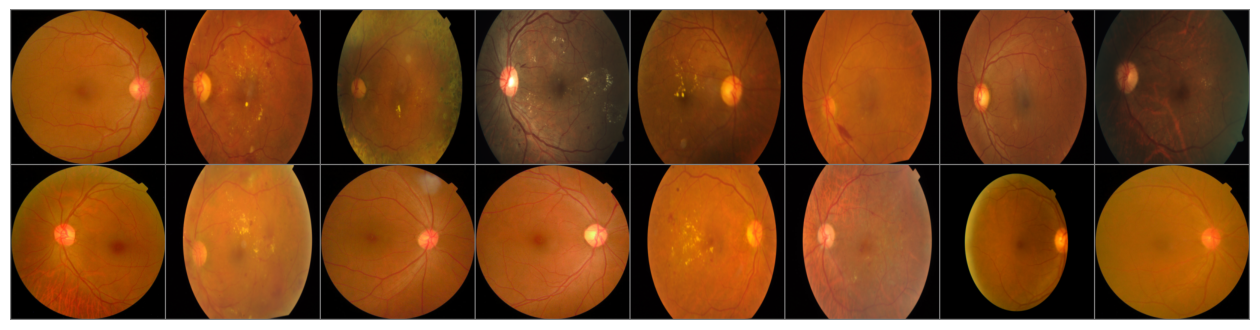

No_DR	Moderate	Proliferative_DR	Severe	Moderate	Moderate	Severe	Moderate	No_DR	Proliferative_DR	No_DR	No_DR	Moderate	Moderate	No_DR	No_DR


In [5]:
# Let us show some of the training images:
def imshow(img):
    # Unnormalize image
    plt.subplots(figsize=(16, 10))
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    
# Get some random training images
images, labels = next(iter(train_dataloader))
print(f'Images batch shape:\t{images.size()}')
print(f'Labels batch shape:\t{labels.size()}')
labels = labels.numpy()
print(f'Labels:\t{labels}')

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print('\t'.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))


## Define Base Convolutional Neural Network

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 256, 5)
        self.fc1 = nn.Linear(952576, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 5)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = torch.flatten(x, 1) # Flatten all dimensions except 1
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

base_model = NeuralNetwork()

In [7]:
# Let's use a Classification Cross-Entropy Loss and SGD
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(base_model.parameters(), lr=0.01, momentum=0.9)

In [8]:
# Function to save the model
def saveModel(model):
    path = './classifier.pth'
    torch.save(model.state_dict(), path)
    

## Train the Model

In [11]:
# Define number of epochs
EPOCHS = 20

# Assign device
device = get_device()
loss_list = []

# Loop over the dataset multiple times
for epoch in range(EPOCHS):
    running_loss = 0.0
    for batch, data in enumerate(train_dataloader):
        # Get the inputs
        # data is a list of [images, labels]
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Sets the model for training
        base_model.train()
        
        # Forward + Backward + Optimize
        base_model = base_model.to(device)
        outputs = base_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
        loss_list.append(running_loss)
        if batch % 100 == 99:
            print(f'[Epoch: {epoch + 1}, Batch:{batch + 1:5d}] - Train Loss: {running_loss / 100:.3f}')

print('\n>>Finish Training!')

Using CUDA device!


## Test Network on the Test Data

In [ ]:
# Let's display an image from the test set to get familiar
images, labels = next(iter(test_dataloader))
labels = labels.cpu().numpy()

# Print images
imshow(torchvision.utils.make_grid(images))
print('Ground truth:\n', '\t'.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))
# print(labels)
# print('\t'.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))


In [ ]:
# Let's see what the neural network thinks these examples above are:
outputs = base_model(images.to(device))

# Get the index of the highest energy for the 5 classes
_, predicted = torch.max(outputs, 1)
predicted = predicted.cpu().numpy()
print('Predicted:\n', '\t'.join(f'{classes[predicted[j]]:5s}' for j in range(BATCH_SIZE)))
# print(predicted)

In [ ]:
correct = 0.0
total = 0.0

# Since we are note training, we don't need to calculate the gradients for our outputs
base_model.eval()
# base_model.to(device)
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # Calculate outputs by running images through the network
        outputs = base_model(images)

        # The class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1) # Returns maximum value of all elements in the input tensor
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images:\t{100 * correct // total} %')



That looks way better tan chance, which is 20% accuracy (randomly picking a class out of 5 classes). 

Seems like the network learned something.


In [ ]:
# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

base_model.cpu()
# No gradient needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data        
        outputs = base_model(images)
        _, predictions = torch.max(outputs, 1)

        # Collect correct predictions por each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[label.item()] += 1
            total_pred[label.item()] += 1

# Print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class {classes[classname]:5s}:\t{accuracy:.1f}%')

In [ ]:
correct_pred.items()